In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from helper import windowed_dataset

TensorFlow 2.x selected.


In [0]:
#Load data
fname = 'data/BTCUSD_2h_2011-09-13_to_2019-10-23_bitstamp.csv'
data = pd.read_csv(fname)
data.set_index('date', inplace=True)
data.head()

,open,high,low,close,volume
date,,,,,
2011-09-13 12:00:00,5.80000000,6.00000000,5.80000000,6.00000000,25.00000000
2011-09-13 14:00:00,5.95000000,5.95000000,5.65000000,5.65000000,24.89598238
2011-09-13 16:00:00,nan,nan,nan,nan,0.00000000
2011-09-13 18:00:00,5.92000000,5.97000000,5.92000000,5.97000000,8.47540000
2011-09-13 20:00:00,nan,nan,nan,nan,0.00000000


In [0]:
#Prepare data 
data = data.interpolate()
data['returns'] = data['high'].pct_change(periods=1)
data.head()

,open,high,low,close,volume,returns
date,,,,,,
2011-09-13 12:00:00,5.80000000,6.00000000,5.80000000,6.00000000,25.00000000,nan
2011-09-13 14:00:00,5.95000000,5.95000000,5.65000000,5.65000000,24.89598238,-0.00833333
2011-09-13 16:00:00,5.93500000,5.96000000,5.78500000,5.81000000,0.00000000,0.00168067
2011-09-13 18:00:00,5.92000000,5.97000000,5.92000000,5.97000000,8.47540000,0.00167785
2011-09-13 20:00:00,5.86333333,5.91166667,5.85666667,5.91166667,0.00000000,-0.00977108


In [0]:

#for i in range (0, data.shape[0]-2):
  #data.loc[data.index[i+2],'SMA_3'] = np.round(((data.iloc[i,4]+ data.iloc[i+1,4] + data.iloc[i+2,4])/3),4)
#data.head()

In [0]:
#Split data into training and validation sets
N = data.shape[0]
split_t = int(N * .66)                               # 2/3 to training & 1/3 to validation

time_train = data.index[1:split_t]                   # skip to first value since it(the return) is NaN
x_train = data['returns'][1:split_t].to_numpy()      # first 2/3
y_train = 100 * data['returns'][2:split_t + 1].to_numpy()  # first 2/3     why do we need 100 here, and why do we use the overlay method here 
time_valid = data.index[split_t:]
x_valid = data['returns'][split_t:-1].to_numpy()     # last 1/3
y_valid = 100 * data['returns'][split_t + 1:].to_numpy()   # last 1/3

(-3, 3)

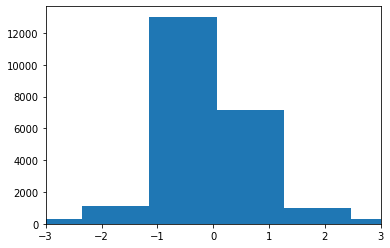

In [0]:
plt.hist(y_train, 100) #what does 100 here means, how do we interpret the graph 
plt.xlim([-3, 3])

In [0]:
batch_sz = 32
win_sz = 48
train_data = windowed_dataset(x_train, y_train, win_sz,
                              batch_sz, kind='class')
valid_data = windowed_dataset(x_valid, y_valid, win_sz,
                              batch_sz, kind='class')

In [0]:
#Build a model 
def get_model(lr):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                               input_shape=[None]),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Dense(1)])

    optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=.9)
    model.compile(loss=tf.keras.losses.binary_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model

In [0]:
def optimize_lr(model, train_data):
    tf.keras.backend.clear_session()
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-8 * 10**(epoch / 20))

    history = model.fit(train_data, epochs=100, callbacks=[lr_schedule])

    fig = plt.figure(figsize=[16, 6])
    ax = fig.add_subplot(121)
    ax.semilogx(history.history["lr"], history.history["loss"])
    # get index of lowest loss
    minloss_i = np.argmin(history.history['loss'])
    # get the learning rate at that index
    min_lr = history.history['lr'][minloss_i]
    # plot best learing rate, and add value to label
    ax.plot([min_lr, min_lr], ax.get_ylim(), 'r',
            label='best lr: {:.5E}'.format(min_lr))

    ax = fig.add_subplot(122)
    ax.semilogx(history.history["lr"], history.history["loss"])
    # ax.set_ylim([0, 1e-4])
    ax.set_xlim([history.history["lr"][0], 1e-5])
    ylim = ax.get_ylim()
    ax.set_ylim([ylim[0] * 1.000025, ylim[-1] * .99933])
    # get index of lowest loss
    minloss_i = np.argmin(history.history['loss'])
    # get the learning rate at that index
    min_lr = history.history['lr'][minloss_i]
    # plot best learing rate, and add value to label
    ax.plot([min_lr, min_lr], ax.get_ylim(), 'r',
            label='best lr: {:.5E}'.format(min_lr))
    # Print the best learning rate
    print('best learning rate:', min_lr)
    ax.set_xlabel('learning rate')
    ax.set_ylabel('loss')
    ax.set_title('Loss as a function of learning rate')
    ax.legend()

    fig.savefig('loss_lr.png')

    # Print the best learning rate
    print('best learning rate:', min_lr)

    return history

In [0]:
model = get_model(lr=1e-8)
history = optimize_lr(model, train_data)

Train for 732 steps
Epoch 1/100
732/732 [==============================] - 60s 82ms/step - loss: 2.0203 - accuracy: 0.5580
Epoch 2/100
732/732 [==============================] - 53s 72ms/step - loss: 1.7351 - accuracy: 0.5606
Epoch 3/100
732/732 [==============================] - 52s 71ms/step - loss: 1.6148 - accuracy: 0.5617
Epoch 4/100
732/732 [==============================] - 50s 68ms/step - loss: 1.5540 - accuracy: 0.5559
Epoch 5/100
732/732 [==============================] - 51s 70ms/step - loss: 1.5032 - accuracy: 0.5516
Epoch 6/100
732/732 [==============================] - 49s 68ms/step - loss: 1.4392 - accuracy: 0.5545
Epoch 7/100
732/732 [==============================] - 50s 68ms/step - loss: 1.3755 - accuracy: 0.5601
Epoch 8/100
732/732 [==============================] - 49s 67ms/step - loss: 1.3481 - accuracy: 0.5553
Epoch 9/100
732/732 [==============================] - 49s 67ms/step - loss: 1.3277 - accuracy: 0.5489
Epoch 10/100
732/732 [==============================]

In [0]:
# 2nd train with best learning rate and more epochs 
tf.keras.backend.clear_session()
best_lr = 7.94328e-04
epochs = 300
model = get_model(lr=best_lr)
history = model.fit(train_data, epochs=epochs, validation_data=valid_data)

# Saves the model in an HDF5 file called 'BidirLSTM_2layer_epochs<EPOCHS>.h5'
model.save('BidirLSTM_2layer_class_epochs%d.h5' % epochs)
# save the history for later plotting
np.save('BidirLSTM_2layer_class_epochs%d' % epochs, history.history)

In [0]:
# Load a saved model
model = tf.keras.models.load_model('BidirLSTM_2layer_class_epochs%d.h5' % epochs)

LSTM validation MSE: 58706.920440, mean forecast: 0.000135


Text(0, 0.5, 'Percent change')

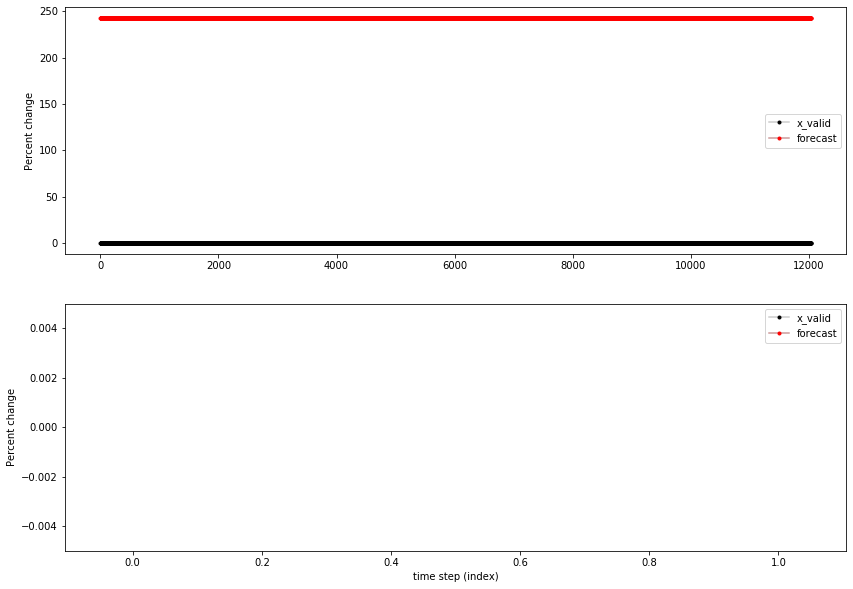

In [0]:
# EVALUATE forcast performance 
forecast = model.predict(x_valid) 
mean_forecast = np.ones(x_valid[win_sz:].shape) * x_valid.mean() 
rnn_mse = mean_squared_error(x_valid[win_sz+1:], forecast[win_sz:-1].flatten())
meanforecast_mse = mean_squared_error(x_valid[win_sz:], mean_forecast)
print('LSTM validation MSE: %.6f, mean forecast: %.6f' % (rnn_mse, meanforecast_mse))


fig = plt.figure(figsize=[14,10])
ax = fig.add_subplot(211)
ax.plot(x_valid[win_sz+1:], '.-', color=[.8]*3, mfc='k', mec='k', label='x_valid')
ax.plot(forecast[win_sz:-1].flatten(), '.-', color=[.8, .6, .6], mfc='r', mec='r', label='forecast')
ax.legend()
ax.set_ylabel('Percent change')

ax = fig.add_subplot(212)
ax.plot(x_valid[win_sz+40001:], '.-', color=[.8]*3, mfc='k', mec='k', label='x_valid')
ax.plot(forecast[win_sz+40000:-1].flatten(), '.-', color=[.8, .6, .6], mfc='r', mec='r', label='forecast')
ax.set_ylim([-.005, 0.005])
ax.legend()
ax.set_xlabel('time step (index)')
ax.set_ylabel('Percent change')

In [0]:
y_true = x_valid[win_sz+1:] > 0
y_hat = forecast[win_sz:-1].flatten() > 0
acc = 100 * (y_true == y_hat).sum() / len(y_true)
chance = max(y_true.mean(), 1 - y_true.mean()) * 100             
print('Forecasting direction of change\n\tAccuracy: %1.3f%% (chance: %1.3f%%)' % (acc, chance))

Forecasting direction of change
	Accuracy: 45.924% (chance: 54.076%)


In [0]:
# Check how many epochs are required to minimize the loss
# Load history saved from training
history = np.load('BidirLSTM_2layer_class_epochs%d.npy' % epochs, allow_pickle=True).item()

In [0]:
history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

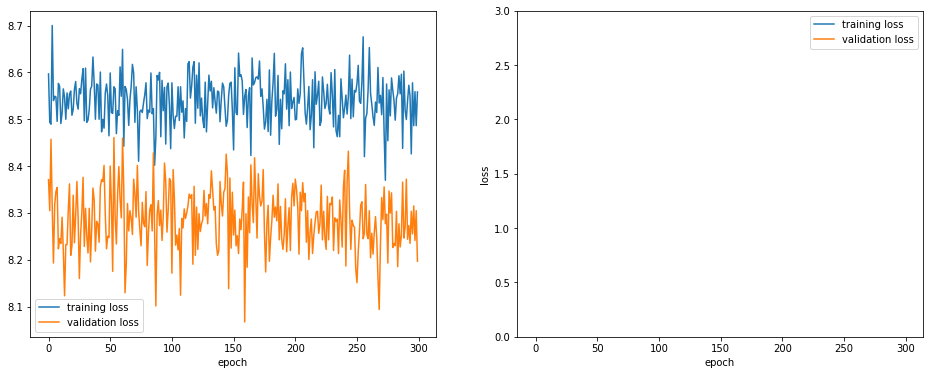

In [0]:
fig = plt.figure(figsize=[16, 6])
ax = fig.add_subplot(121)
ax.plot(history['loss'], label='training loss')
ax.plot(history['val_loss'], label='validation loss')
ax.set_xlabel('epoch')
ax.legend()

ax = fig.add_subplot(122)
ax.plot(history['loss'], label='training loss')
ax.plot(history['val_loss'], label='validation loss')
# ax.set_ylim([7.2193185e-06, 7.219321e-06])
ax.set_ylim([0, 3])
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend()

In [2]:
#Get testing data
from helper import get_klines
klines = get_klines(start_t=[2019, 10, 18, 0, 0, 0], end_t=[2019, 11, 18, 0, 0, 0], interval='2h')
klines.to_csv('data/BTCUSD_2h_2011-10-18_to_2019-11-18_binance.csv')

2019-11-18 01:59


In [3]:
klines.head()

,open_ts,open,high,low,close,volume,close_ts,returns
date,,,,,,,,
2019-10-18 01:59:59.999000+00:00,1.571357e+12,8070.71,8109.61,8050.00,8109.60,1522.883840,1.571364e+12,NaN
2019-10-18 03:59:59.999000+00:00,1.571364e+12,8109.60,8115.00,8055.05,8064.81,1628.399317,1.571371e+12,0.000665
2019-10-18 05:59:59.999000+00:00,1.571371e+12,8065.65,8072.54,7856.89,7908.74,5276.010216,1.571378e+12,-0.005232
2019-10-18 07:59:59.999000+00:00,1.571378e+12,7908.74,7927.74,7864.77,7911.60,3966.324236,1.571386e+12,-0.017937
2019-10-18 09:59:59.999000+00:00,1.571386e+12,7911.59,7923.87,7816.01,7909.76,4759.095133,1.571393e+12,-0.000488


In [4]:
klines.tail()

,open_ts,open,high,low,close,volume,close_ts,returns
date,,,,,,,,
2019-11-17 17:59:59.999000+00:00,1.574006e+12,8529.52,8557.49,8525.16,8542.05,1509.126611,1.574014e+12,0.001533
2019-11-17 19:59:59.999000+00:00,1.574014e+12,8541.23,8567.55,8530.40,8553.19,1776.443029,1.574021e+12,0.001176
2019-11-17 21:59:59.999000+00:00,1.574021e+12,8552.96,8635.00,8519.00,8548.82,3194.598694,1.574028e+12,0.007873
2019-11-17 23:59:59.999000+00:00,1.574028e+12,8548.99,8553.00,8455.55,8502.40,1858.701267,1.574035e+12,-0.009496
2019-11-18 01:59:59.999000+00:00,1.574035e+12,8502.87,8503.52,8456.00,8483.94,1726.831323,1.574042e+12,-0.005785


In [5]:
# Backtesting 
!pip install git+git://github.com/anfederico/Gemini.git
!pip install bokeh
from gemini import engine
from helper import load_binance_klines
import os
import numpy as np
import tensorflow as tf

  Cloning git://github.com/anfederico/Gemini.git to /tmp/pip-req-build-rdsun5pa
  Running command git clone -q git://github.com/anfederico/Gemini.git /tmp/pip-req-build-rdsun5pa
  Created wheel for gemini: filename=gemini-1.0.0-cp36-none-any.whl size=37371 sha256=0392ff4b75ad3e96a2c34208fc418af6a32dba3e5e37c6d15abad4ad21471bec
  Stored in directory: /tmp/pip-ephem-wheel-cache-mu3a4870/wheels/96/c4/35/d73bfb8dc4304cc3bea43263d5efcf2f1b3985876acdcc3191
Successfully built gemini


In [0]:
# Helper function for pre-processing 
def preprocess(model, data, win_sz=30):
    """
    """
    forecast = model.predict(data['returns'].to_numpy())
    data['forecast'] = np.nan
    data['forecast'][1:] = forecast[:-1].flatten().copy()

    # drop the 1st two rows since the forcast in those is NaN
    data = data.dropna(axis=0)
    # or
    # drop the first win_sz values since there wasn't enough prev data for
    # full forecast
    #data = data[win_sz:]
    return data

In [0]:
# Trade logic 
def logic(account, lookback):
    try:

        current_t = lookback.iloc[-1]


        if current_t['forecast'] > 0.00075:  # forcasted price increase

            entry_price = current_t['close'] # price when the market close 
            risk = 0.7
            entry_capital = account.buying_power * risk
            if entry_capital > 0:
                account.enter_position('long', entry_capital, entry_price)

        elif current_t['forecast'] < 0.00075:  # forcasted price decrease
            exit_price = current_t['close']
            for position in account.positions:
                if position.type == 'long':
                    account.close_position(position, 0.7, exit_price) 

    except ValueError:
        pass  # Handles lookback errors in beginning of dataset

In [8]:
# Prerun and backtesting 
# load pre-trainied model
model = tf.keras.models.load_model('BidirLSTM_2layer_class_epochs300.h5')
fname = os.path.join('data', 'BTCUSD_2h_2011-10-18_to_2019-11-18_binance.csv')
# load data
data = load_binance_klines(fname)
# pre-process
data = preprocess(model, data)
# # initialize backtest
backtest = engine.backtest(data)
# Start backtesting custom logic with 10 (BTC) intital capital
backtest.start(10, logic)
# # check results
backtest.results()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


-------------- Results ----------------

Buy and Hold : 5.19%
Net Profit   : 0.52
Strategy     : 7.2%
Net Profit   : 0.72
Longs        : 370
Sells        : 0
Shorts       : 0
Covers       : 0
--------------------
Total Trades : 370

---------------------------------------


In [0]:
!pip install python.binance

  Using cached https://files.pythonhosted.org/packages/b3/a8/80f39763ea30f5d62088ec6796c93df83ad79ebe634253ee8e93e7b42d8e/python_binance-0.7.4-py2.py3-none-any.whl


In [0]:
import helper as h
import trading_helper as th
import numpy as np
import pandas as pd
from binance.client import Client
import time
from datetime import datetime, timezone, timedelta

In [0]:
# Trading strategy 
def strategy(model, keys_fname, log_fname, win_sz=48, trading_interval='2h'):
    """
    Arguments
    --------- 
    model            : Some trained forecasting model
    keys_fname       : File name to the keys, see below
    log_fname        : You will need to log the trades you submit to Binance. 
                       The file name should be on the format "tradingbot_group<number>_<date_time>.log". 
                       E.g. "tradingbot_group1_2019-11-13_00:23:23.log"
    win_sz           : The window size that you specified when training the model, 
                       i.e. how many time steps of historical data the model needs for a forecast.
    trading_interval : How often the trading bot will query data from Binance, 
                       make a new forecast and decide whether to trade. 
                       E.g. '1min', '5min', '15min', '30min', '1h', '2h', '4h', '6h', '12h', '1d' or '1w'.
    """
    
    # use the keys stored in KEYS_FNAME to initialize the Binance client
    client = th.init_client(keys_fname)
    
    # convert the trading_interval string to seconds (int)
    interval_s = th.interval_string_to_seconds(trading_interval)
    
    # initialize the log file
    th.log(log_fname, new_log=True)
        
    # initialize trading with historical data
    t = datetime.utcnow()
    # timedelta(weeks=2) -> 2 weeks back in time
    t = th.UTC('time') - timedelta(weeks=2)
    # get data to begin forecasting from
    data = h.get_klines([t.year, t.month, t.day, t.hour, t.minute, t.second], interval=trading_interval)
    
    # forecast 
    forecast = model.predict(data['returns'][-win_sz:])
    
    while True:
    
        try:

            if forecast[-1] > 0.00075:  # since our forcasted accuracy is less than chance, preidicted price decrease -> sell

                # decide on how to set the entry price
                entry_price = data['high'][-1] 
                risk = 0.7 
                # get the current balance
                balance = client.get_asset_balance(asset='USDT')
                entry_capital = np.float64(balance['free']) * risk # balance['free'] is a str -> convert to float
                
                if entry_capital > 0:
                    order = th.limit_buy(client, 'BTCUSDT', entry_price, quantity=entry_capital)
                    
                    th.log(log_fname, order_type='NEW_BUY', quantity=order['origQty'],
                        price=entry_price, time=th.UTC('iso'))

            elif forecast[-1] < 0.00075:  # forcasted price decrease
                exit_price = data['low'][-1] 
                balance = client.get_asset_balance(asset='BTC')
                risk = 0.7
                exit_capital = np.float64(balance['free']) * risk # balance['free'] is a str -> convert to float

                if entry_capital > 0:
                    order = th.limit_sell(client, 'BTCUSDT', exit_price, quantity=exit_capital)
                    th.log(log_fname, order_type='NEW_SELL', quantity=order['origQty'],
                        price=exit_price, time=th.UTC('iso'))
                    
            # pause/sleep for the trading_interval
            time.sleep(interval_s)
            # get last time from data
            t = data.index[-1]
            # update data 
            tmp = h.get_klines([t.year, t.month, t.day, t.hour, t.minute, t.second], interval=trading_interval)
            data.append(tmp)
            forecast = model.predict(data['returns'][-win_sz:])
                
        except ValueError:
            pass  # Handles lookback errors in beginning of dataset

In [0]:
# create the Jason file 
#import json 
#data = {}
#data["api_key"] = "gglFmXh8VIvkalLXauz3TIU5A3OtQeLLpuGS21TSHEgPtDsqzUeFmKLtSu3awUsr"
#data["secret_key"] = "oajw02UHWSiPLWHbr4qAaTEj1HALmcE7wuuNVV8JuTF0vBCmenTYzHrPn4fG8cxL"
#with open ('group<2>_keys.json', 'w') as outfile:
  #json.dump (data, outfile)

In [0]:
# Live trading on Binance 
# load pre-trainied model

model_name = 'BidirLSTM_2layer_class_epochs%d.h5' % (epochs)
model_dir = os.path.join('models', model_name)
fname_model = '%s/%s_epochs%d.h5' % (model_dir, model_name, epochs)
model = tf.keras.models.load_model('BidirLSTM_2layer_class_epochs%d.h5' % (epochs))
keys_fname = 'group<2>_keys.json' # set this file name to your file name
log_fname = 'tradingbot_group<2>_<{}>.log'.format(th.UTC('iso')[:-10]) #
win_sz = 48  # example
trading_interval = '2h' # example
strategy(model, keys_fname, log_fname, win_sz=win_sz, trading_interval=trading_interval)

NameError: ignored